# Runup models

_This notebook is from the [py-wave-runup](https://github.com/chrisleaman/py-wave-runup) examples from [Vitousek et al. (2017)](https://www.nature.com/articles/s41598-017-01362-7)._

:::{note}
Runup is the final stage of a wave’s landward propagation, and thus the determinant of the most landward position a wave can reach before receding seaward. Runup above the local ocean level outside the surf zone results from a combination of two processes: 
+ wave induced setup and 
+ swash. 
:::


```{eval-rst}
.. figure:: ../_static/runup.jpg
  :width: 70 %
  :alt: The water-level components that contribute to coastal flooding.
  :align: center

  The water-level components that contribute to coastal flooding from Vitousek et al. (2017).
```


Past research has focussed on modelling maximum wave runup values, most commonly **Rmax** and **R2%**. 

**Rmax** is the greatest elevation obtained by a single runup event within a given time period and is therefore a function of record length. 

**R2%** is a statistical measure of the elevation exceeded by only 2% of all runup or swash events within a time period.


In this example, we will evaluate the accuracy of the **Stockdon et al (2006) runup
model**. 

> Stockdon, H. F., Holman, R. A., Howd, P. A., & Sallenger, A. H. (2006). Empirical parameterization of setup, swash, and runup. Coastal Engineering, 53(7), 573–588. https://doi.org/10.1016/j.coastaleng.2005.12.005


To do this, we will use the compiled wave runup observations provided by **Power
et al (2018)**.

> Power, H.E., Gharabaghi, B., Bonakdari, H., Robertson, B., Atkinson, A.L., Baldock, T.E., 2018. Prediction of wave runup on beaches using Gene-Expression Programming and empirical relationships. Coastal Engineering. https://doi.org/10.1016/j.coastaleng.2018.10.006

The **Stockdon et al (2006)** wave runup model comprises of two relationships, one for
*dissipative* beaches (i.e. $\zeta < 0.3$) Eqn (18):

\begin{align}R_{2} = 0.043(H_{s}L_{p})^{0.5}\end{align}

and a seperate relationship for *intermediate* and *reflective* beaches (*i.e.*
$\zeta > 0.3$):

\begin{align}R_{2} = 1.1 \left( 0.35 \beta (H_{s}L_{p})^{0.5} + \frac{H_{s}L_{p}(
    0.563 \beta^{2} +0.004)^{0.5}}{2} \right)\end{align}

First, let's import our required packages:


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

import waverunup as ru

%matplotlib inline

Let's import the Power et al (2018) runup data, which is included in this
package.



In [2]:
import pandas as pd

# Manually define names for each column
names = [
    "dataset",
    "beach",
    "case",
    "lab_field",
    "hs",
    "tp",
    "beta",
    "d50",
    "roughness",
    "r2",
]

df = pd.read_csv('../pracenv/dataset/power18.csv', encoding="utf8", names=names, skiprows=1)
print(df.head())

        dataset      beach    case lab_field        hs   tp   beta       d50  \
0  ATKINSON2017  AUSTINMER  AU24-1         F  0.739477  6.4  0.102  0.000445   
1  ATKINSON2017  AUSTINMER  AU24-2         F  0.729347  6.4  0.101  0.000445   
2  ATKINSON2017  AUSTINMER  AU24-3         F  0.729347  6.4  0.115  0.000445   
3  ATKINSON2017  AUSTINMER  AU24-4         F  0.719217  6.4  0.115  0.000445   
4  ATKINSON2017  AUSTINMER  AU24-5         F  0.719217  6.4  0.115  0.000445   

   roughness     r2  
0   0.001112  1.979  
1   0.001112  1.862  
2   0.001112  1.695  
3   0.001112  1.604  
4   0.001112  1.515  


We can see that this dataset gives us $H_{s}$ (significant wave height),
$T_{p}$ (peak wave period), $\tan \beta$ (beach slope). Let's import
the Stockdon runup model and calculate the estimated $R_{2}$ runup value for
each row in this dataset.



In [3]:
# Initalize the Stockdon 2006 model with values from the dataset
sto06 = ru.models.Stockdon2006(Hs=df.hs, Tp=df.tp, beta=df.beta)

# Append a new column at the end of our dataset with Stockdon 2006 R2 estimations
df["sto06_r2"] = sto06.R2

# Check the first few rows of observed vs. modelled R2
print(df[["r2", "sto06_r2"]].head())

      r2  sto06_r2
0  1.979  0.645571
1  1.862  0.636336
2  1.695  0.704238
3  1.604  0.699330
4  1.515  0.699330


Now let's create a plot of observed R2 values vs. predicted R2 values:



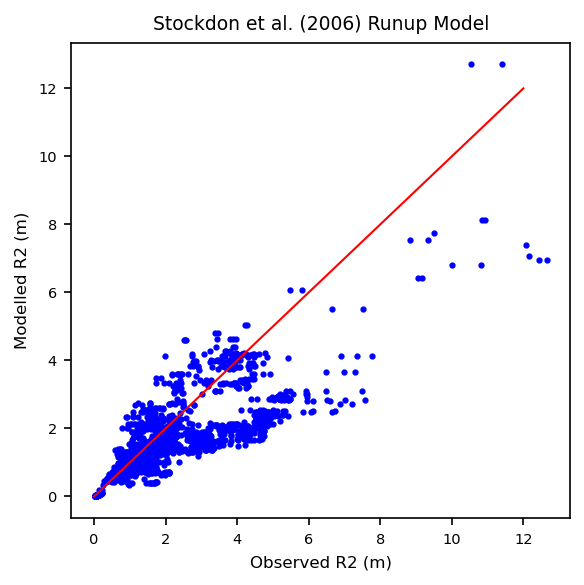

In [4]:
# Plot data
fig, ax1 = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
ax1.plot(df.r2, df.sto06_r2, "b.", markersize=4, linewidth=0.5)

# Add 1:1 line to indicate perfect fit
ax1.plot([0, 12], [0, 12], "r-", linewidth=1)

# Add axis labels
ax1.set_xlabel("Observed R2 (m)", fontsize=8)
ax1.set_ylabel("Modelled R2 (m)", fontsize=8)
ax1.set_title("Stockdon et al. (2006) Runup Model", fontsize=9)

plt.xticks(fontsize=7, rotation=0)
plt.yticks(fontsize=7, rotation=0)

plt.tight_layout()

We can see there is a fair amount of scatter, especially as we get larger wave
runup heights. This indicates that the model might not be working as well as we
might have hoped.

Let's also check RMSE and coefficient of determination values:



In [5]:
print("R2 Score: {0:.2f}".format(r2_score(df.r2, df.sto06_r2)))
print("RMSE: {0:.2f} m".format(np.sqrt(mean_squared_error(df.r2, df.sto06_r2))))

R2 Score: 0.54
RMSE: 1.21 m


## Power et al. (2018) model

Let us try the Power et al. (2018) model:

In [6]:
df = pd.read_csv('../pracenv/dataset/power18.csv', encoding="utf8", names=names, skiprows=1)

In [7]:
# Initalize the Nielsen 2009 model with values from the dataset
pow18 = ru.models.Power2018(Hs=df.hs, Tp=df.tp, beta=df.beta, r=df.roughness)

# Append a new column at the end of our dataset with Stockdon 2006 R2 estimations
df["pow18_r2"] = pow18.R2

# Check the first few rows of observed vs. modelled R2
print(df[["r2", "pow18_r2"]].head())

      r2  pow18_r2
0  1.979  1.034144
1  1.862  1.015685
2  1.695  1.127796
3  1.604  1.115673
4  1.515  1.115673


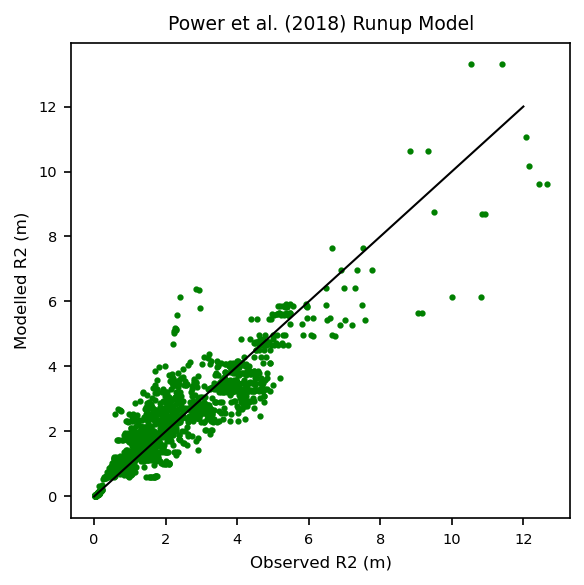

In [8]:
# Plot data
fig, ax1 = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
ax1.plot(df.r2, df.pow18_r2, "g.", markersize=4, linewidth=0.5)

# Add 1:1 line to indicate perfect fit
ax1.plot([0, 12], [0, 12], "k-", linewidth=1)

# Add axis labels
ax1.set_xlabel("Observed R2 (m)", fontsize=8)
ax1.set_ylabel("Modelled R2 (m)", fontsize=8)
ax1.set_title("Power et al. (2018) Runup Model", fontsize=9)

plt.xticks(fontsize=7, rotation=0)
plt.yticks(fontsize=7, rotation=0)

plt.tight_layout()

In [9]:
print("R2 Score: {0:.2f}".format(r2_score(df.r2, df.pow18_r2)))
print("RMSE: {0:.2f} m".format(np.sqrt(mean_squared_error(df.r2, df.pow18_r2))))

R2 Score: 0.82
RMSE: 0.75 m
